Derive spec2vec embeddings of MS/MS spectra

In [1]:
import os
import sys
import gensim
import numpy as np

ROOT = os.path.dirname(os.getcwd())
#path_data = os.path.join(ROOT, 'data')
path_data = 'C:\\Users\\Gosia\\Desktop\\'
sys.path.insert(0, ROOT)

Import dataset to create embeddings from, here: pre-processed dataset "Unique InchiKeys"

In [38]:
from matchms.importing.load_from_msp import load_from_msp
spectrums = list(load_from_msp('C:\\Users\\Gosia\\Desktop\\MoNA-export-GC-MS_Spectra-msp\\MoNA-export-GC-MS_Spectra.msp'))


In [57]:
from matchms.filtering import normalize_intensities
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import require_minimum_number_of_peaks

def apply_my_filters(s):
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = normalize_intensities(s)
    s = select_by_relative_intensity(s, intensity_from=0.05, intensity_to=1)
    return s

In [58]:
# apply filters to the data
spectrums_classical = [apply_my_filters(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums = [s for s in spectrums_classical if s is not None]

print("{} remaining spectra.".format(len(spectrums)))

18898 remaining spectra.


In [59]:
inchi_dict = {}
for s in spectrums:
    ik = s.metadata.get('inchikey','')
    init_ik = ik.split('-')[0]
    if not init_ik in inchi_dict:
        inchi_dict[init_ik] = [s]
    else:
        inchi_dict[init_ik].append(s)


In [60]:
singletons = set([i for i,v in inchi_dict.items() if len(v) == 1])
multis = set([i for i,v in inchi_dict.items() if len(v) > 1 and i != ''])
print(len(singletons), len(multis))

5869 3274


Load pretrained spec2vec model

In [51]:
from spec2vec import Spec2Vec
from spec2vec import SpectrumDocument

documents = [SpectrumDocument(s, n_decimals=2) for s in spectrums]


In [52]:
from spec2vec.model_building import train_new_word2vec_model

path_models = os.path.join(path_data, "trained_models")
model_file = os.path.join(path_models, "spec2vec_gcms_model_170.model")

iterations = [1, 3, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]

# Train model with default parameters
model = train_new_word2vec_model(documents, iterations, model_file,size=170)

The value of size is set from 300 (default) to 170
  Epoch 1 of 100.Change in loss after epoch 1: 141085.375
Saving model with name: C:\Users\Gosia\Desktop\trained_models\spec2vec_gcms_model_170_iter_1.model
  Epoch 2 of 100.Change in loss after epoch 2: 121939.71875
  Epoch 3 of 100.Change in loss after epoch 3: 131649.1875
Saving model with name: C:\Users\Gosia\Desktop\trained_models\spec2vec_gcms_model_170_iter_3.model
  Epoch 4 of 100.Change in loss after epoch 4: 121501.28125
  Epoch 5 of 100.Change in loss after epoch 5: 121173.375
Saving model with name: C:\Users\Gosia\Desktop\trained_models\spec2vec_gcms_model_170_iter_5.model
  Epoch 6 of 100.Change in loss after epoch 6: 116296.5
  Epoch 7 of 100.Change in loss after epoch 7: 112556.3125
  Epoch 8 of 100.Change in loss after epoch 8: 114341.5625
  Epoch 9 of 100.Change in loss after epoch 9: 110579.0625
  Epoch 10 of 100.Change in loss after epoch 10: 115802.25
Saving model with name: C:\Users\Gosia\Desktop\trained_models\spe

In [63]:
queries = [s[0] for s in inchi_dict.values() if len(s) > 1]
libs = [s[0] for s in inchi_dict.values() if len(s) == 1]
for s_ in [s[1:] for s in inchi_dict.values() if len(s) > 1]:
    for s in s_:
        libs.append(s)

Create spectrum "documents"

In [110]:
from rdkit.Chem import MolFromSmiles, MolToSmiles
from rdkit.Chem.inchi import MolFromInchi, MolToInchi
from rdkit.Chem.rdMolDescriptors import CalcExactMolWt, CalcMolFormula

def f(specs):
    successes = []
    for s in specs:
        try:
            mol = MolFromSmiles(s.get('smiles'))
        except Exception as e:
            pass
        if mol is None:
            #pprint(s.metadata)
            try:
                mol = MolFromInchi(s.get('inchi'))
            except:
                pass
        if mol is None:
            #pprint(s.metadata)
            try:
                mol = MolFromInchi(s.get('inchikey'))
            except:
                pass
        if mol is not None:
            exact_mass_smi = CalcExactMolWt(mol)
            #print(mol,exact_mass_smi,s.get('parent_mass'))
            #if s.get('parent_mass') is None
            successes.append(s)
            s.set('very_exact_mass', exact_mass_smi)
    return successes

In [111]:
queries = f(queries)
libs = f(libs)

In [112]:
from spec2vec import Spec2Vec
from spec2vec import SpectrumDocument

documents_query = [SpectrumDocument(s, n_decimals=2) for s in queries]
documents_lib = [SpectrumDocument(s, n_decimals=2) for s in libs]
print(documents_query)

[<spec2vec.SpectrumDocument.SpectrumDocument object at 0x0000016F431E7DF0>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x0000016F431E7820>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x0000016F431E77C0>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x0000016F431E7880>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x0000016F431E7BE0>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x0000016F431E7A90>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x0000016F431E7E20>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x0000016F431E7C70>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x0000016F48723340>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x0000016F431E7D90>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x0000016F431E71C0>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x0000016F431E7940>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x0000016F431E7A30>, <spec2vec.SpectrumDocume

In [114]:
from cosine_calc import get_hits

hits,_ = get_hits( documents_query, documents_lib, metaKey='very_exact_mass', spec2vec_model=model, precursor_tol=1,
                                                        intensity_weighting_power=intensity_weighting_power,
                                                        allowed_missing_percentage=allowed_missing_percentage, passatutto=True)
len(hits)

3275

In [116]:
# Calculating true q-value scores
from q_value_calc import calculate_q_value
q_list_true = calculate_q_value(hits)

In [120]:
from knockoffs import generate_knockoffs, evaluate_knockoff_performance
#diags = [0.00000070, 0.00000075, 0.00000080, 0.00000085, 0.00000090, 0.00000095]
diags = [0.0000191,0.000191,0.000191,0.00191]
q_list_knockoffs = {}
for diag in diags:
    try:
        knockoff_documents = generate_knockoffs(model,documents_lib,allowed_missing_percentage=allowed_missing_percentage,n_components=170, covariance_type='diag', diagonal_matrix=diag)

        hits_knockoffs, _ = get_hits(documents_query, knockoff_documents, decoys=True, spec2vec_model=model, precursor_tol=1, metaKey="very_exact_mass",
                                                            intensity_weighting_power=intensity_weighting_power,
                                                            allowed_missing_percentage=allowed_missing_percentage, passatutto=True)
        q_list_knockoffs[diag] = calculate_q_value(hits+hits_knockoffs,True)
    except:
        pass

Embedding vector size: 170


AssertionError: Joint covariance matrix has to be positive definite

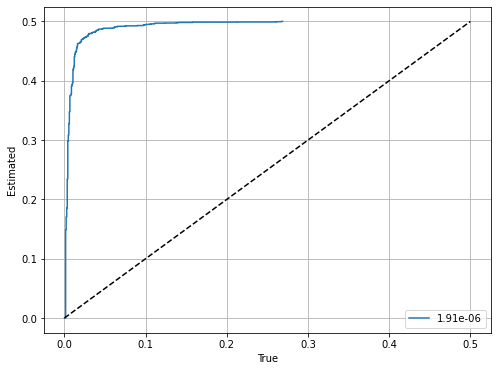

In [119]:
# plot estimated and true q-values
def combine_true_est(q_val_true,q_val_est):
    res = []
    q_idx = 0
    for q_e, _, score in q_val_est:
        while q_idx < len(q_val_true)-1 and q_val_true[q_idx+1][2] >= score:
            q_idx += 1
        res.append((score, q_val_true[q_idx][0], q_e))
    return res
        
to_plot = {}
for k,v in q_list_knockoffs.items():
    to_plot[k] = list(zip(*combine_true_est(q_list_true, v)))[1], list(zip(*combine_true_est(q_list_true, v)))[2]

import plot_q_vals
plot_q_vals.plot_q_vals( to_plot )